In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Split the target zones and the objective zones

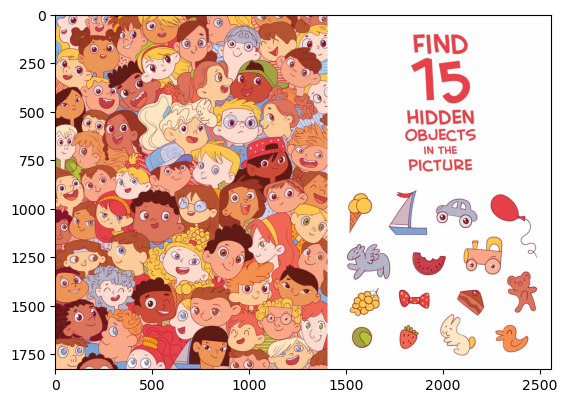

In [2]:
image = cv2.imread("Finding/1.jpg")
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

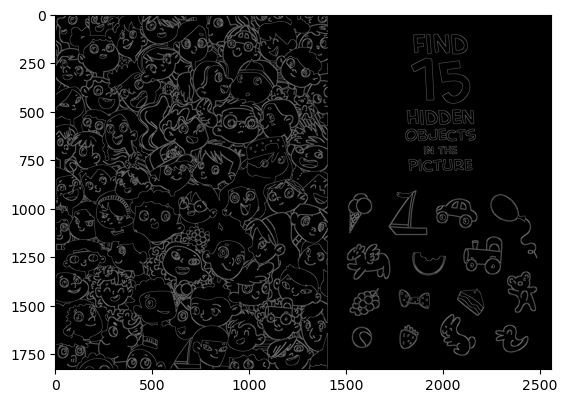

In [3]:
img_gaussian = cv2.GaussianBlur(gray_img, (5, 5), 0)
img_edge_det = cv2.Canny(img_gaussian, 100, 200)
plt.imshow(img_edge_det, cmap='gray')

In [4]:
lines = cv2.HoughLinesP(img_edge_det, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

In [5]:
def is_collinear_and_perpendicular_to_horizontal_axis(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    if x1 == x2 and x2 == x3 and x3 == x4:
        if y1 == y3 and y2 == y4:
            return False
        return True
    return False

In [6]:
def detect_crop_lines(lines):
    for i in range(0, len(lines)):
        cropped_line = lines[i][0]
        for j in range(i + 1, len(lines)):
            if is_collinear_and_perpendicular_to_horizontal_axis(cropped_line,
                                                                lines[j][0]):
                print(cropped_line, lines[j][0])
                return cropped_line, lines[j][0]
    return None, None

In [7]:
cropped_line, line = detect_crop_lines(lines)
print(cropped_line)


[1406 1591 1406 1170] [1406  782 1406  593]
[1406 1591 1406 1170]


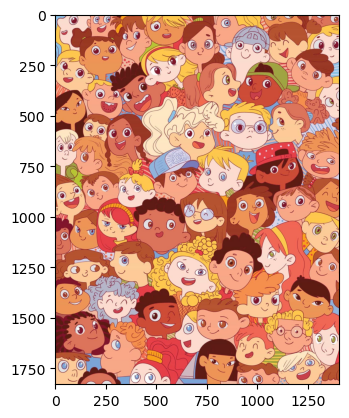

In [8]:
crop_img = image[:, :cropped_line[0]]
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))

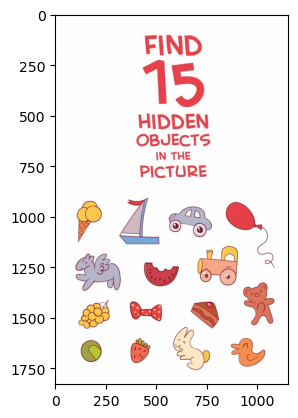

In [9]:
object_img = image[:, cropped_line[0]:]
plt.imshow(cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB))

## Extract all objects from the objective zone

In [10]:
![ -f frozen_east_text_detection.pb ] || wget https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb

In [11]:
def detect_text_regions(image, min_confidence=0.5):
    net = cv2.dnn.readNet('frozen_east_text_detection.pb')

    h, w = image.shape[:2]
    new_w, new_h = (320, 320)
    rW, rH = w / float(new_w), h / float(new_h)

    blob = cv2.dnn.blobFromImage(image, 1.0, (new_w, new_h),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    scores, geometry = net.forward([
        'feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'])

    rectangles = []
    confidences = []
    for y in range(geometry.shape[2]):
        for x in range(geometry.shape[3]):
            score = scores[0, 0, y, x]
            if score < min_confidence:
                continue

            offsetX, offsetY = x * 4.0, y * 4.0
            angle = geometry[0, 4, y, x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h_ = geometry[0, 0, y, x]
            w_ = geometry[0, 1, y, x]

            endX = int(offsetX + (cos * w_ + sin * h_))
            endY = int(offsetY - (sin * w_ - cos * h_))
            startX = int(offsetX - w_/2)
            startY = int(offsetY - h_/2)

            rectangles.append((startX, startY, endX - startX, endY - startY))
            confidences.append(float(score))

    boxes = cv2.dnn.NMSBoxes(rectangles, confidences, min_confidence, 0.4)

    result = []
    if boxes is not None:
        for i in boxes:
            i = i[0] if isinstance(i, (list, tuple, np.ndarray)) else i
            (x, y, w, h) = rectangles[i]
            result.append((int(x * rW), int(y * rH), int(w * rW), int(h * rH)))
    return result

def overlaps_with_text(x, y, w, h, text_boxes):
    for (tx, ty, tw, th) in text_boxes:
        if (x < tx + tw and x + w > tx and y < ty + th and y + h > ty):
            return True
    return False

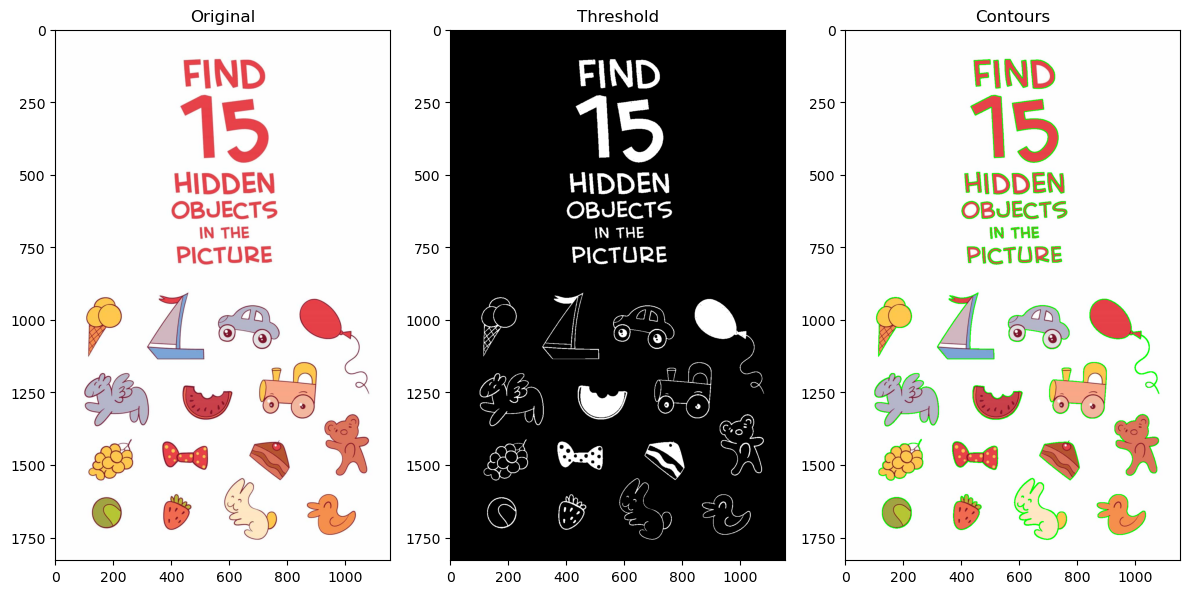

In [12]:

gray = cv2.cvtColor(object_img, cv2.COLOR_BGR2GRAY)

text_boxes = detect_text_regions(object_img)

ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_image = object_img.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

os.makedirs('objects', exist_ok=True)

objects = []
for i, contour in enumerate(contours):
    if cv2.contourArea(contour) > 150:
        x, y, w, h = cv2.boundingRect(contour)

        if overlaps_with_text(x, y, w, h, text_boxes):
            continue

        object_roi = object_img[y:y+h, x:x+w]
        objects.append(object_roi)
        cv2.imwrite(f'objects/object_{i}.jpg', object_roi)

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(131), plt.imshow(cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(thresh, cmap='gray'), plt.title('Threshold')
plt.subplot(133), plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)), plt.title('Contours')
plt.tight_layout()
plt.show()

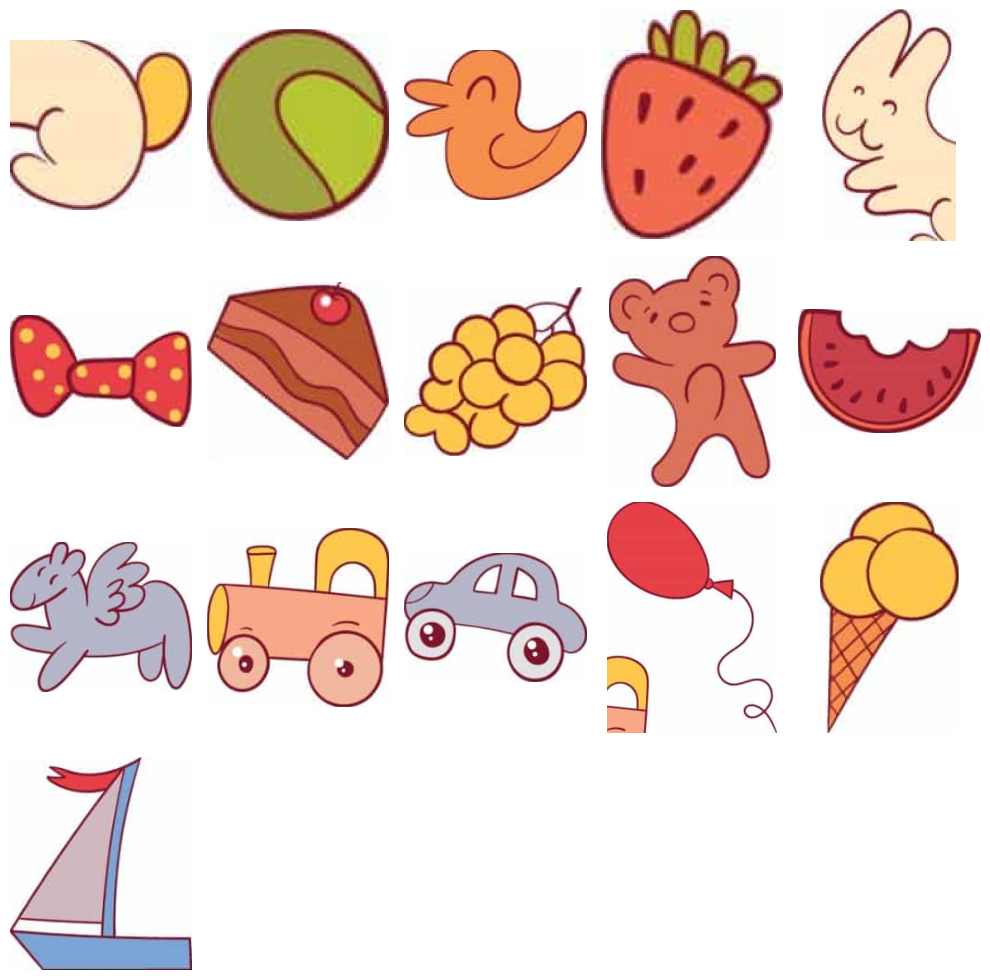

In [13]:
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = (len(objects) + columns - 1) // columns
for i, object_img in enumerate(objects):
    if i < columns * rows:
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(cv2.cvtColor(object_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.tight_layout()
plt.show()

## Finding objects

In [14]:
def non_maximum_suppression(boxes, scores, overlap_threshold=0.5):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)
    
    x1, y1 = boxes[:, 0], boxes[:, 1]
    x2, y2 = boxes[:, 2], boxes[:, 3]
    
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]
    
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        
        order = order[np.where(iou <= overlap_threshold)[0] + 1]
    
    return keep

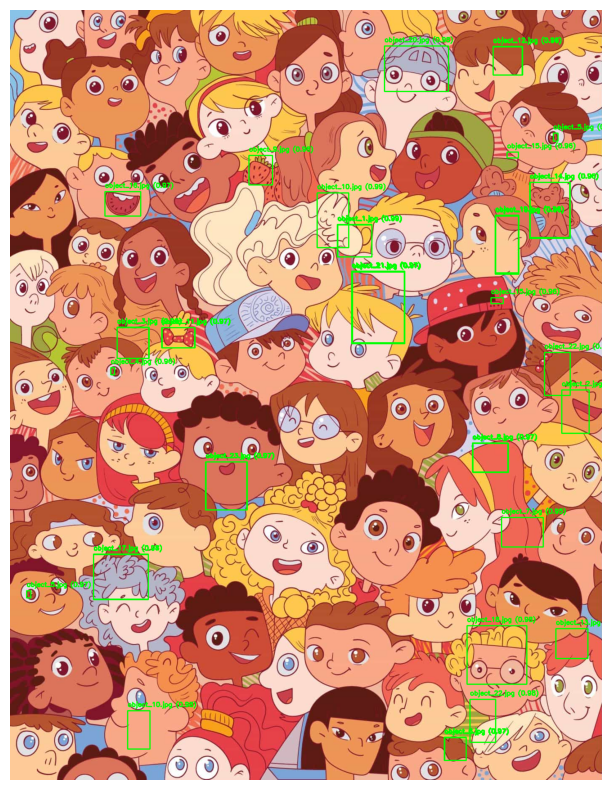

In [16]:
image_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
gray_blurred = cv2.GaussianBlur(image_gray, (3, 3), 0)

template_folder = "objects/"
template_files = [f for f in os.listdir(template_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
scales = np.linspace(0.5, 1.2, 80)
threshold = 0.6
methods = [cv2.TM_CCOEFF_NORMED, cv2.TM_SQDIFF_NORMED, cv2.TM_CCORR_NORMED]

detected_boxes = []
detected_scores = []
labels = []

for template_file in template_files:
    template_path = os.path.join(template_folder, template_file)
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    if template is None:
        continue 
    
    template_blurred = cv2.GaussianBlur(template, (3, 3), 0)
    h, w = template.shape[:2]
    
    best_confidence = -1
    best_loc = None
    best_w, best_h = 0, 0
    best_method = None
    best_result = None
    
    for scale in scales:
        resized = cv2.resize(template_blurred, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR)
        
        if resized.shape[0] > gray_blurred.shape[0] or resized.shape[1] > gray_blurred.shape[1]:
            continue
        
        for method in methods:
            result = cv2.matchTemplate(gray_blurred, resized, method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            
            if method == cv2.TM_SQDIFF_NORMED:
                score = -min_val
                loc = min_loc
            else:
                score = max_val
                loc = max_loc
            
            if score > best_confidence:
                best_confidence = score
                best_loc = loc
                best_h, best_w = resized.shape[:2]
                best_method = method
                best_result = result
    
    if best_confidence >= np.percentile(best_result, 90):
        top_left = best_loc
        bottom_right = (top_left[0] + best_w, top_left[1] + best_h)
        detected_boxes.append([top_left[0], top_left[1], bottom_right[0], bottom_right[1]])
        detected_scores.append(best_confidence)
        labels.append(template_file)


keep = non_maximum_suppression(detected_boxes, detected_scores, overlap_threshold=0.3)
for i in keep:
    box = detected_boxes[i]
    cv2.rectangle(crop_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    cv2.putText(crop_img, f"{labels[i]} ({detected_scores[i]:.2f})", 
                (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()